In [124]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import  tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score

# Import The data

In [125]:
data= pd.read_csv("/kaggle/input/house-data/kc_house_data.csv")
print(data.head())
data.dtypes

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     lo

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [126]:
#check the number of data point 
print(len(data))
#check the number of features
print(len(data.columns))
#check the different data tpye
print(data.dtypes.unique())


21613
21
[dtype('int64') dtype('O') dtype('float64')]


Since we have python object data type lets chech

In [127]:
data.select_dtypes(include=['O']).columns.tolist

<bound method IndexOpsMixin.tolist of Index(['date'], dtype='object')>

So there is "date" index with python time stamped we will ignore it

In [128]:
#check number of column with null value
print(data.isnull().any().sum()," / ",len(data.columns))
#check number of data point with null value
print(data.isnull().any(axis=1).sum(), ' / ',len(data))

0  /  21
0  /  21613


So the DAta that we are working on pritty much structured and does not have any null value so we can move to the next part wheere we will be finding the corellation between features and target value

# 2.Correlation between features and target value

In [129]:
features = data.iloc[:,3:].columns.tolist()# we are excluding id,date,price tolist converting the feature into the list
target = data.iloc[:,2].name #extructing the target name


In [130]:
from scipy.stats import pearsonr
correlation={}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f +' vs ' + target
    correlation[key] = pearsonr(x1,x2)[0]
    
print(correlation)    
    

{'bedrooms vs price': 0.3083495981456382, 'bathrooms vs price': 0.525137505413962, 'sqft_living vs price': 0.7020350546118, 'sqft_lot vs price': 0.08966086058710011, 'floors vs price': 0.25679388755071847, 'waterfront vs price': 0.2663694340306021, 'view vs price': 0.39729348829450417, 'condition vs price': 0.03636178912899755, 'grade vs price': 0.667434256020237, 'sqft_above vs price': 0.6055672983560781, 'sqft_basement vs price': 0.3238160207119839, 'yr_built vs price': 0.054011531494792715, 'yr_renovated vs price': 0.12643379344089292, 'zipcode vs price': -0.05320285429832561, 'lat vs price': 0.3070034799952187, 'long vs price': 0.021626241039306708, 'sqft_living15 vs price': 0.585378903579568, 'sqft_lot15 vs price': 0.08244715251948596}


In [131]:
data_correlations=pd.DataFrame(correlation,index=['Value']).T
data_correlations.loc[data_correlations['Value'].sort_values(ascending=False).abs().index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


1. From the above we can see that top 5 features are the best correlated features
2. Let's plot the best 2 features jointly 

In [132]:
y =  data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True)

x =data.loc[:,target].sort_values()
y

,sqft_living,grade,price
1149,670,3,75000.0
15293,780,5,78000.0
465,430,4,80000.0
16198,730,5,81000.0
8274,860,6,82000.0
...,...,...,...
1448,8000,12,5350000.0
4411,9200,13,5570000.0
9254,9890,13,6885000.0
3914,10040,11,7062500.0


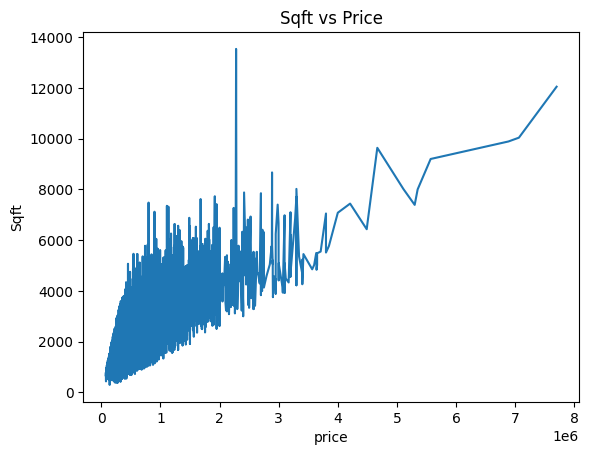

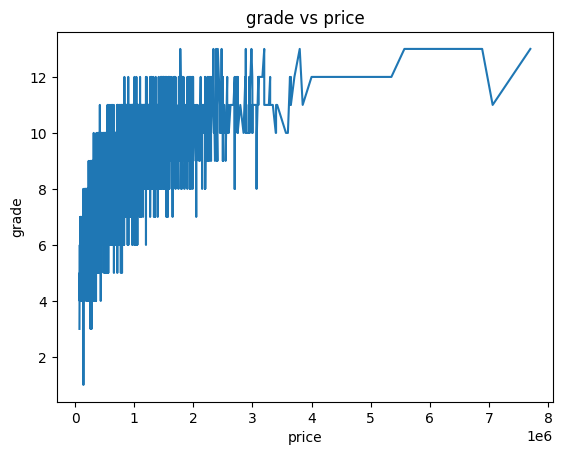

In [133]:
#plt.subplot(3,1,1)
# plot of sqft vs prices
plt.plot(x,y['sqft_living'])
plt.title('Sqft vs Price')
plt.xlabel('price')
plt.ylabel('Sqft')
plt.show()
#plot of grade vs prices
plt.plot(x,y['grade'])
plt.title('grade vs price')
plt.xlabel('price')
plt.ylabel('grade')
plt.show()

# 3.Pridicting House seles price
we will be using 5 highly correlated feature for that

In [134]:
model = linear_model.LinearRegression()
X = data.iloc[:,3:].values
y= data.loc[:,'price'].values
X

array([[ 3.00000e+00,  1.00000e+00,  1.18000e+03, ..., -1.22257e+02,
         1.34000e+03,  5.65000e+03],
       [ 3.00000e+00,  2.25000e+00,  2.57000e+03, ..., -1.22319e+02,
         1.69000e+03,  7.63900e+03],
       [ 2.00000e+00,  1.00000e+00,  7.70000e+02, ..., -1.22233e+02,
         2.72000e+03,  8.06200e+03],
       ...,
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  2.00700e+03],
       [ 3.00000e+00,  2.50000e+00,  1.60000e+03, ..., -1.22069e+02,
         1.41000e+03,  1.28700e+03],
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  1.35700e+03]])

Test train split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.1,random_state=None)

In [140]:
fit_model = model.fit(X_train,y_train)
fit_model

LinearRegression()

In [141]:
cv_scores = cross_val_score(fit_model, X, y, cv=10) 
cv_scores.mean()

0.6951875247730521

In [142]:
fit_model.score(X_test,y_test)


0.70099842460949

In [144]:
# Fit the model on the entire dataset to calculate mean squared error
from sklearn.metrics import mean_squared_error
y_pred = fit_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error on the entire dataset:", mse)

Mean Squared Error on the entire dataset: 40475421909.973236


In [146]:
rmse = np.sqrt(mse)
rmse

201185.04395201258